# Spatial network analysis code breakfast

## <font color="#3333cc"><a name="top_row"></a> Contents </font>
 - section 1. [a very short introduction](#section_1)
 - section 2. [used packages](#section_2)
 - section 3. [data import](#section_3)
 - section 4. [feature selection](#section_4)
 - section 5. [building the graph](#section_5)
 - section 6. [Ranking the shortest path](#section_6)
 - section 7. [Export the distance matrix](#section_7)

 

### <font color="#3333cc"><a name="section_1"></a> 1. a very short introduction</font>

### Short intro
[presentation network analysis](spatial_graph_analytics.pdf)

#### useful links
 - [Theoretical foundations of graphs](http://networksciencebook.com/chapter/2#bridges)
 - [Spatial analysis online book, spatial network analysis](https://www.spatialanalysisonline.com/HTML/index.html?overview_-_network_analysis.htm)

### <font color="#3333cc"><a name="section_2"></a>2. used packages</font>

In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
from owslib.wfs import WebFeatureService
import owslib
import datetime
from progressbar import ProgressBar

/home/nico/apps/environments/pynetworkanalysis/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import bfs_poi_afstand as bfs

### package versions

In [3]:
print('pandas:', pd.__version__)
print('Geopandas:', gpd.__version__)
print('networkx:', nx.__version__)
print('owslib:', owslib.__version__)

pandas: 1.1.3
Geopandas: 0.8.1
networkx: 2.5
owslib: 0.20.0


### <font color="#3333cc"><a name="section_3"></a>3. data import</font>

Go back to [table of Contents](#top_row)

## Download the data
(manually)  
**Metadata in the data catalogue**

__[Loop- en fietsnetwerk Amsterdam metadata](https://data.amsterdam.nl/datasets/7hGzsRXqWSGqHw/loop-en-fietsnetwerk-amsterdam/)__

**Direct link to zipped file**  
__[Loop- en fietsnetwerk Amsterdam  (196 MB)](https://api.data.amsterdam.nl/dcatd/datasets/7hGzsRXqWSGqHw/purls/1)__


## setup your basedir for the files and the url for your services

In [4]:
# basedir for your files, ending with as slash
data_dir='/home/data/tmp/'
# url for the neigbourhoods, districts and cityp parts
wfs_gebieden='https://api.data.amsterdam.nl/v1/wfs/gebieden/'

## Import all the required data
 - city parts of Amsterdam
 - edges
 - nodes and poi's
 - addresses

### import City parts of Amsterdam
We use this dataset to limit the size of the spatial network
#### documentation:
https://api.data.amsterdam.nl/v1/docs/wfs-datasets/gebieden.html

In [5]:
WfsUrl = wfs_gebieden
wfs = WebFeatureService(url=WfsUrl, version='2.0.0')
print('The title of the dataset:',wfs.identification.title)
print('available map layers: \n',list(wfs.contents))

The title of the dataset: gebieden
available map layers: 
 ['app:bouwblokken', 'app:buurten', 'app:wijken', 'app:ggwgebieden', 'app:ggpgebieden', 'app:stadsdelen']


In [6]:
# request city parts
layer='stadsdelen'
response = wfs.getfeature(typename=layer, outputFormat='geojson')

In [7]:
# write the response to disk..
f_stadsdelen=data_dir + 'stadsdelen.geojson'
print(f_stadsdelen)
with open(f_stadsdelen, 'wb') as file:
    file.write(response.read())

/home/nico/data/tmp/stadsdelen.geojson


In [8]:
# Read the file into a geopadas dataframe
gdf_stadsdelen = gpd.read_file(f_stadsdelen)

#### Remark:
This specfic wfs service delivers historial data. Therefore we have to filter the last known instances.

In [9]:
print('number of city parts:',gdf_stadsdelen.shape[0])

number of city parts: 31


#### Filter on the most recent object instance

In [10]:
gdf_stadsdelen=gdf_stadsdelen[gdf_stadsdelen['eind_geldigheid'].isna() == True]
print('number of city parts:',gdf_stadsdelen.shape[0])

number of city parts: 8


coordinate system: epsg:28992


<AxesSubplot:>

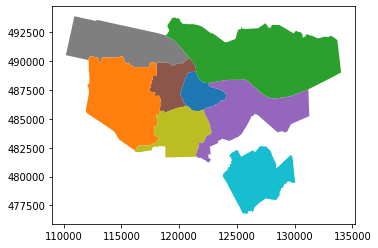

In [11]:
print('coordinate system:',gdf_stadsdelen.crs)
gdf_stadsdelen.plot(column='naam')

<AxesSubplot:>

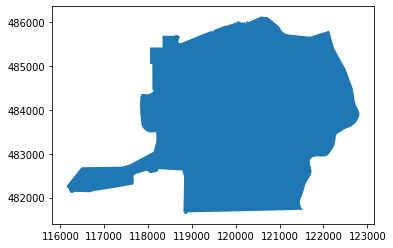

In [12]:
gdf_stadsdeel_zuid=gdf_stadsdelen[gdf_stadsdelen['naam'] == 'Zuid']
gdf_stadsdeel_zuid.plot()

##  edges

In [13]:
gdf_network_edges=gpd.read_file(data_dir + 'adam_netwerk_voetfiets_edges.gpkg',
                                mask=gdf_stadsdelen[gdf_stadsdelen.naam=='Zuid'])
# for the sake of consistency, only take the elements which are within the city part
# Make a spatial join
gdf_network_edges_zuid = gpd.sjoin(gdf_network_edges, gdf_stadsdeel_zuid, how="inner", op="within")

In [14]:
gdf_network_edges.head(3)

,datum_extractie,fid_pk,straatnaam,ind_voetfiets,wegklasse,hoogteniveau,ind_brug,ind_tunnel,ind_ov_bus,ind_ov_spoor,...,max_breedte,gewogen_gemiddelde_breedte,poi_id,poi_type,lengte_intersectie_water,lengteklasse_intersectie_water,weight,id_startpoint,id_endpoint,geometry
0,20201020,191837,None,Y,bgt_voetpad,0,None,None,None,None,...,2.48989,2.27495,NaN,geen_poi,NaN,NaN,19.83,93469,93468,"LINESTRING (116331.318 482151.733, 116331.678 ..."
1,20201020,257410,None,Y,osm_footway,0,None,None,None,None,...,NaN,NaN,NaN,geen_poi,NaN,NaN,44.76,93472,93464,"LINESTRING (116333.727 482152.122, 116335.539 ..."
2,20201020,256778,None,Y,osm_path,0,None,None,None,None,...,NaN,NaN,NaN,geen_poi,NaN,NaN,95.26,93595,93611,"LINESTRING (116354.405 482158.269, 116358.352 ..."


## nodes and pois

In [15]:
# adam_netwerk_voetfiets_nodes_poi.gpkg
gdf_nodes_poi=gpd.read_file(data_dir + 'adam_netwerk_voetfiets_nodes_poi.gpkg',
                           mask=gdf_stadsdeel_zuid)
# for the sake of consistency, only take the elements which are within the city part
# Make a spatial join
gdf_nodes_poi_zuid = gpd.sjoin(gdf_nodes_poi, gdf_stadsdeel_zuid, how="inner", op="within")

In [16]:
print('number of rows:',gdf_nodes_poi.shape[0])
print('number of pois:',gdf_nodes_poi[gdf_nodes_poi['poi_type'] != 'node'].shape[0])

gdf_nodes_poi.head(3)

number of rows: 136506
number of pois: 27502


,datum_extractie,node_id,poi_id,bron_id,poi_type,geometry
0,20201020,224913,NaN,NaN,node,POINT (118129.739 483554.181)
1,20201020,224876,NaN,NaN,node,POINT (118065.565 483567.164)
2,20201020,224875,NaN,NaN,node,POINT (118065.568 483562.925)


## A little exploration..
### Which poi types do we have?

In [17]:
gdf_nodes_poi_zuid.groupby(by='poi_type').agg('count')

,datum_extractie,node_id,poi_id,bron_id,geometry,index_right,code,naam,volgnummer,documentdatum,identificatie,documentnummer,eind_geldigheid,ligt_in_gemeente,begin_geldigheid,registratiedatum,id
poi_type,,,,,,,,,,,,,,,,,
lps,375,375,375,375,375,375,375,375,375,375,375,375,0,375,375,375,375
node,109004,109004,0,0,109004,109004,109004,109004,109004,109004,109004,109004,0,109004,109004,109004,109004
ov_halte,250,250,250,250,250,250,250,250,250,250,250,250,0,250,250,250,250
sps,13,13,13,13,13,13,13,13,13,13,13,13,0,13,13,13,13
vot_cluster,26864,26864,26864,26864,26864,26864,26864,26864,26864,26864,26864,26864,0,26864,26864,26864,26864


## addresses
The addresses are related (one to many, or one tot one).  
We can use these to apply a filter on the poi's which are related to addresses.

In [18]:
# adam_netwerk_voetfiets_poi_adressen.gpkg
gdf_poi_adressen=gpd.read_file(data_dir + 'adam_netwerk_voetfiets_poi_adressen.gpkg',
                              mask=gdf_stadsdelen[gdf_stadsdelen.naam=='Zuid'])
# for the sake of consistency, only take the elements which are within the city part
# Make a spatial join
gdf_poi_adressen_zuid = gpd.sjoin(gdf_poi_adressen, gdf_stadsdeel_zuid, how="inner", op="within")

In [19]:
print('number of rows:',gdf_poi_adressen.shape[0])
gdf_poi_adressen_zuid.head(2)

number of rows: 93611


,datum_extractie,poi_id,poi_type,obj_type,obj_id,obj_status,obj_gebruik,hoofdadres,openbareruimtenaam,huisnummer,...,naam,volgnummer,documentdatum,identificatie,documentnummer,eind_geldigheid,ligt_in_gemeente,begin_geldigheid,registratiedatum,id
0,20201020,18257,vot_cluster,vot,0363010000927081,Verblijfsobject in gebruik,woonfunctie,0363200000383849,Honingen,41,...,Zuid,3,2015-06-23,03630011872038,3B/2015/134,None,{'identificatie': '0363'},2015-01-01,2018-10-25T10:18:00+00:00,03630011872038.3
1,20201020,18257,vot_cluster,vot,0363010000927082,Verblijfsobject in gebruik,woonfunctie,0363200000383850,Honingen,42,...,Zuid,3,2015-06-23,03630011872038,3B/2015/134,None,{'identificatie': '0363'},2015-01-01,2018-10-25T10:18:00+00:00,03630011872038.3


### Which object functions do we have?

In [20]:
gdf_poi_adressen_zuid.groupby(by='obj_gebruik').agg('count')

,datum_extractie,poi_id,poi_type,obj_type,obj_id,obj_status,hoofdadres,openbareruimtenaam,huisnummer,huisletter,...,naam,volgnummer,documentdatum,identificatie,documentnummer,eind_geldigheid,ligt_in_gemeente,begin_geldigheid,registratiedatum,id
obj_gebruik,,,,,,,,,,,,,,,,,,,,,
bijeenkomstfunctie,916,916,916,916,916,916,916,916,916,80,...,916,916,916,916,916,0,916,916,916,916
gezondheidszorgfunctie,105,105,105,105,105,105,105,105,105,19,...,105,105,105,105,105,0,105,105,105,105
industriefunctie,821,821,821,821,821,821,821,821,821,140,...,821,821,821,821,821,0,821,821,821,821
kantoorfunctie,2411,2411,2411,2411,2411,2411,2411,2411,2411,422,...,2411,2411,2411,2411,2411,0,2411,2411,2411,2411
logiesfunctie,88,88,88,88,88,88,88,88,88,15,...,88,88,88,88,88,0,88,88,88,88
onbekend,387,387,387,387,387,387,387,387,387,160,...,387,387,387,387,387,0,387,387,387,387
onderwijsfunctie,175,175,175,175,175,175,175,175,175,22,...,175,175,175,175,175,0,175,175,175,175
overige gebruiksfunctie,2595,2595,2595,2595,2595,2595,2595,2595,2595,233,...,2595,2595,2595,2595,2595,0,2595,2595,2595,2595
sportfunctie,94,94,94,94,94,94,94,94,94,7,...,94,94,94,94,94,0,94,94,94,94


<AxesSubplot:>

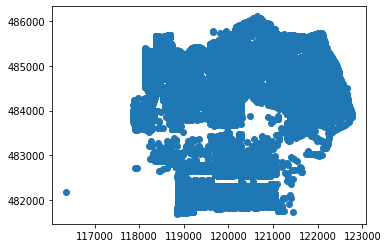

In [21]:
gdf_poi_adressen_zuid.plot()

## <font color="#3333cc"><a name="section_4"></a>4. feature selection</font>
Go back to [table of Contents](#top_row)

## Prepare the data for graph analytics

In this section we need to prepare the following DataFrames:
 - gdf_edges
 - gdf_nodes
 - gdf_poi
 
 The poi's will be filtered using addresses

### edges
Get the edges, no further filtering is necessary.
We need the following columns:
 - fid_pk: unique edge_id
 - id_startpoint: id of the startpoint of the edge (relates to node_id)
 - id_endpoint: id of the endpoint of the edge (relates to node_id)
 - the weight (cost) of the edge. In this case only the length of the edge is used

In [22]:
# From the edges we need id_startpoint, id_endpoint,fid_pk, and weight
gdf_edges=gdf_network_edges_zuid[['fid_pk','id_startpoint', 'id_endpoint','weight','geometry']]
gdf_edges.head(3)

,fid_pk,id_startpoint,id_endpoint,weight,geometry
0,191837,93469,93468,19.83,"LINESTRING (116331.318 482151.733, 116331.678 ..."
2,256778,93595,93611,95.26,"LINESTRING (116354.405 482158.269, 116358.352 ..."
3,46162,93611,93610,6.42,"LINESTRING (116448.507 482153.128, 116451.584 ..."


### nodes
For the nodes we need the following:
 - first column: node_id , unique id of the node
 - second column: geometry, the point geometry in Well Known Text notation (WKT)

In [23]:
gdf_nodes=gdf_nodes_poi_zuid[['node_id','geometry']]
gdf_nodes.head(3)

,node_id,geometry
0,224913,POINT (118129.739 483554.181)
1,224876,POINT (118065.565 483567.164)
2,224875,POINT (118065.568 483562.925)


### POI 
#### Poins Of Interest
With the BFS algorithm we search the shortest path from a single point to all the other pois in the Graph
In this notebook example the **'from poi'** are all the healthcare service points, and the **'to_poi'** are all the dwellings.

The poi_type of the dwellings / addresses must be mapped to a single type" **'address_poi'**
 - lps (house boats)
 - sps (non-buildings on land, caravan parcs)
 - vot_cluster (clustered units within buildings)

![datamodel](model_relations.png)

## reclassify poi_type
Within the key registration addresses and buildings different object types can have an address.  
Therefore reclassification is required.

### Define the function to reclassify

In [24]:
def reclass_poi_type(row):
    if row['poi_type'] == 'lps':
        return 'address'
    elif row['poi_type']=='sps':
        return 'address'
    
    elif row['poi_type'] == 'vot_cluster':
        return 'address'    
    else:
        return row['poi_type']

#### Perform the reclassification for gdf_nodes_poi_zuid

In [25]:
gdf_nodes_poi_zuid['poi_type_gen'] = gdf_nodes_poi_zuid.apply(reclass_poi_type, axis=1)

In [26]:
gdf_nodes_poi_zuid.groupby(by='poi_type_gen').agg('count')

,datum_extractie,node_id,poi_id,bron_id,poi_type,geometry,index_right,code,naam,volgnummer,documentdatum,identificatie,documentnummer,eind_geldigheid,ligt_in_gemeente,begin_geldigheid,registratiedatum,id
poi_type_gen,,,,,,,,,,,,,,,,,,
address,27252,27252,27252,27252,27252,27252,27252,27252,27252,27252,27252,27252,27252,0,27252,27252,27252,27252
node,109004,109004,0,0,109004,109004,109004,109004,109004,109004,109004,109004,109004,0,109004,109004,109004,109004
ov_halte,250,250,250,250,250,250,250,250,250,250,250,250,250,0,250,250,250,250


#### Perform the wrangling for gdf_poi_adressen
In this section we select the addresses, which we later use to filter poi's

#### Select the _from_ and _to_ addresses
_from_: gezondheidszorgfunctie,  
_to_: woonfunctie

In [27]:
# make selection of from where we want to calc the distance
# filter all the addresses which have a health service and dwellings
gebruik_filter= ['gezondheidszorgfunctie','woonfunctie']
gdf_address_selection=gdf_poi_adressen_zuid[gdf_poi_adressen_zuid.obj_gebruik.isin(gebruik_filter)]
# 
gdf_address_selection.groupby(by='obj_gebruik').agg('count')

,datum_extractie,poi_id,poi_type,obj_type,obj_id,obj_status,hoofdadres,openbareruimtenaam,huisnummer,huisletter,...,naam,volgnummer,documentdatum,identificatie,documentnummer,eind_geldigheid,ligt_in_gemeente,begin_geldigheid,registratiedatum,id
obj_gebruik,,,,,,,,,,,,,,,,,,,,,
gezondheidszorgfunctie,105,105,105,105,105,105,105,105,105,19,...,105,105,105,105,105,0,105,105,105,105
woonfunctie,83975,83975,83975,83975,83975,83975,83975,83975,83975,12040,...,83975,83975,83975,83975,83975,0,83975,83975,83975,83975


In [28]:
## get the unique values
gdf_address_selection=gdf_address_selection[['poi_id','obj_gebruik']].drop_duplicates()

In [29]:
gdf_address_selection.groupby(by='obj_gebruik').agg('count')

,poi_id
obj_gebruik,
gezondheidszorgfunctie,99
woonfunctie,23046


In [30]:
gdf_address_selection.head(3)

,poi_id,obj_gebruik
0,18257,woonfunctie
2,18256,woonfunctie
14,22723,woonfunctie


### select the pois which are input for the graph
 - from: gezondheidszorgfunctie
 - to: woonfunctie

### Filter the poi based on the address selection

In [31]:
gdf_poi= gdf_nodes_poi_zuid.merge(gdf_address_selection,on='poi_id')
gdf_poi.head(5)
gdf_poi=gdf_poi[['node_id','poi_id','obj_gebruik']]
#rename
gdf_poi.columns=('node_id','poi_id','poi_type')
gdf_poi.head(3)

,node_id,poi_id,poi_type
0,93596,136906.0,woonfunctie
1,107945,44352.0,woonfunctie
2,108647,120235.0,woonfunctie


In [32]:
gdf_poi.groupby(by='poi_type').agg('count')

,node_id,poi_id
poi_type,,
gezondheidszorgfunctie,100,100
woonfunctie,23048,23048


## <font color="#3333cc"><a name="section_5"></a>5. building the graph</font>

Go back to [table of Contents](#top_row)  
  
This particular bfs helper functions requires a specific input and structure.  
The construction of the graph an de BFS-algo is written in native python by Niels Prins.

In [33]:
# generate input_data
#DataFrame.to_records(index=True, column_dtypes=None, index_dtypes=None)[source]
df_nodes = pd.DataFrame(gdf_nodes)
rec_nodes = df_nodes.to_records(index=False)
g_nodes = bfs.get_data('node',rec_nodes)

node


In [34]:
df_edges = pd.DataFrame(gdf_edges[['fid_pk', 'id_startpoint', 'id_endpoint', 'weight' ]])
rec_edges = df_edges.values.tolist()
g_edges = bfs.get_data('edge',rec_edges)

edge


In [35]:
df_poi = pd.DataFrame(gdf_poi)
rec_poi = df_poi.to_records(index=False)
g_poi = bfs.get_data('poi',rec_poi)

poi


### Build the Graph

In [36]:
# create_graph(poi_type_from, poi_type_to,node_data,edge_data,poi_data)
graph = bfs.create_graph('gezondheidszorgfunctie','woonfunctie',g_nodes,g_edges,g_poi)

Created  136486  network nodes
Created  185496  network edges

Number of begin nodes: 100
Number of end nodes: 23041


### Get the Matrix

In [37]:
# get_distance_matrix(graph, threshold=cutoff)
d_matrix = bfs.get_distance_matrix(graph, threshold=1000.0)

In [38]:
df_matrix = pd.DataFrame.from_records(d_matrix, columns=['van_node', 'node_id', 'distance'])
print ('number of rows in frame:', len(df_matrix))

number of rows in frame: 235592


In [39]:
df_matrix

,van_node,node_id,distance
0,229120,229659.0,18.42000000000000126121335597
1,229120,229661.0,25.76000000000000111910480883
2,229120,229665.0,31.69000000000000083488771453
3,229120,229105.0,27.64999999999999924504834325
4,229120,229672.0,39.58000000000000051514348344
...,...,...,...
235587,577039,523439.0,954.4799999999999780553316951
235588,577039,523411.0,962.0799999999999777000603271
235589,577039,523407.0,967.0999999999999772737346857
235590,577039,523406.0,971.4699999999999773803160960


## Join distance matrix with pois
The Graph operations were performes on nodes.  
To have a meaningful distance matrix we need no (re) join the points of interest..

### join the poi's 'dwellings'

In [40]:
df_distancematrix_poi_stag=pd.merge(df_poi,df_matrix, on='node_id', how='left')

In [41]:
df_distancematrix_poi_stag=pd.merge(df_poi,df_matrix, on='node_id', how='left')
df_distancematrix_poi_stag.head(3)

,node_id,poi_id,poi_type,van_node,distance
0,93596,136906.0,woonfunctie,NaN,NaN
1,107945,44352.0,woonfunctie,320384.0,931.7999999999999838351527615
2,108647,120235.0,woonfunctie,320384.0,832.2999999999999898303570945


### join the pois 'gezondheidszorgfunctie'

In [42]:
# select the required poi's
df_poi_gezondheidszorg=df_poi[df_poi['poi_type'] == 'gezondheidszorgfunctie']
df_poi_gezondheidszorg.columns=('van_node','van_poi_id','van_poi_type')

In [43]:
# merge...
df_distancematrix_poi=pd.merge(df_distancematrix_poi_stag,df_poi_gezondheidszorg, on='van_node', how='left')

In [44]:
# round the calculated distance
df_distancematrix_poi.distance = df_distancematrix_poi.distance.astype(float)
df_distancematrix_poi['distance'] = df_distancematrix_poi['distance'].round(decimals=0)
df_distancematrix_poi

,node_id,poi_id,poi_type,van_node,distance,van_poi_id,van_poi_type
0,93596,136906.0,woonfunctie,NaN,NaN,NaN,NaN
1,107945,44352.0,woonfunctie,320384.0,932.0,16269.0,gezondheidszorgfunctie
2,108647,120235.0,woonfunctie,320384.0,832.0,16269.0,gezondheidszorgfunctie
3,108663,113278.0,woonfunctie,320384.0,863.0,16269.0,gezondheidszorgfunctie
4,108702,100334.0,woonfunctie,320384.0,753.0,16269.0,gezondheidszorgfunctie
...,...,...,...,...,...,...,...
236218,566313,96626.0,woonfunctie,574006.0,989.0,49313.0,gezondheidszorgfunctie
236219,566313,96626.0,woonfunctie,575348.0,732.0,148189.0,gezondheidszorgfunctie
236220,566313,96626.0,woonfunctie,574007.0,994.0,131754.0,gezondheidszorgfunctie
236221,566313,96626.0,woonfunctie,570188.0,687.0,84216.0,gezondheidszorgfunctie


## <font color="#3333cc"><a name="section_6"></a>6. Ranking the shortest path</font>

Go back to [table of Contents](#top_row)  

## Ranking
The distance matrix calculated the shortest path between the pairs reachable poi's.  
For the purpose of analysis and filtering the distances are ranked for each poi.

In [45]:
df_distancematrix_poi['distance_rank'] = df_distancematrix_poi.groupby('poi_id')['distance'].rank(method='min')

In [46]:
#sorting
#df_distancematrix_poi_sort=df_distancematrix_poi.sort_values(by=['poi','distance'] ,kind='mergesort')
#df_distancematrix_poi_sort
df_distancematrix_poi.sort_values(by=['poi_id', 'distance'], ascending=True)

,node_id,poi_id,poi_type,van_node,distance,van_poi_id,van_poi_type,distance_rank
179952,555091,12987.0,woonfunctie,555537.0,128.0,58166.0,gezondheidszorgfunctie,1.0
179945,555091,12987.0,woonfunctie,519232.0,389.0,41683.0,gezondheidszorgfunctie,2.0
179953,555091,12987.0,woonfunctie,518710.0,468.0,144851.0,gezondheidszorgfunctie,3.0
179946,555091,12987.0,woonfunctie,518701.0,473.0,170341.0,gezondheidszorgfunctie,4.0
179944,555091,12987.0,woonfunctie,519117.0,480.0,61926.0,gezondheidszorgfunctie,5.0
...,...,...,...,...,...,...,...,...
48844,343815,171889.0,woonfunctie,345997.0,601.0,118021.0,gezondheidszorgfunctie,2.0
48842,343815,171889.0,woonfunctie,324808.0,721.0,55873.0,gezondheidszorgfunctie,3.0
48846,343815,171889.0,woonfunctie,351570.0,861.0,102879.0,gezondheidszorgfunctie,4.0
48843,343815,171889.0,woonfunctie,325028.0,869.0,51868.0,gezondheidszorgfunctie,5.0


In [47]:
df_distancematrix_poi_rank1=df_distancematrix_poi[df_distancematrix_poi['distance_rank'] ==1.0]
df_distancematrix_poi_rank1

,node_id,poi_id,poi_type,van_node,distance,van_poi_id,van_poi_type,distance_rank
1,107945,44352.0,woonfunctie,320384.0,932.0,16269.0,gezondheidszorgfunctie,1.0
2,108647,120235.0,woonfunctie,320384.0,832.0,16269.0,gezondheidszorgfunctie,1.0
3,108663,113278.0,woonfunctie,320384.0,863.0,16269.0,gezondheidszorgfunctie,1.0
4,108702,100334.0,woonfunctie,320384.0,753.0,16269.0,gezondheidszorgfunctie,1.0
5,108703,65576.0,woonfunctie,320384.0,742.0,16269.0,gezondheidszorgfunctie,1.0
...,...,...,...,...,...,...,...,...
236192,566078,100843.0,woonfunctie,577039.0,371.0,45302.0,gezondheidszorgfunctie,1.0
236198,566079,92501.0,woonfunctie,577039.0,378.0,45302.0,gezondheidszorgfunctie,1.0
236205,566080,125815.0,woonfunctie,577039.0,357.0,45302.0,gezondheidszorgfunctie,1.0
236213,566076,125814.0,woonfunctie,577039.0,348.0,45302.0,gezondheidszorgfunctie,1.0


### For convenience of use, add geometry of the poi's

In [48]:
gdf_poi_geom = gdf_nodes_poi_zuid[['poi_id','geometry']]
df_distancematrix_poi_geom = pd.merge(df_distancematrix_poi_rank1,gdf_poi_geom, on='poi_id', how='inner')

<AxesSubplot:>

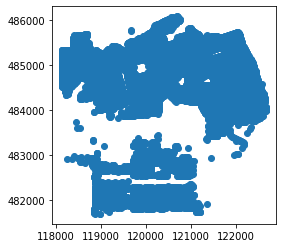

In [49]:
# Transform the panda to the Geo
gdf_distancematrix_poi_geom =  gpd.GeoDataFrame(df_distancematrix_poi_geom, crs="EPSG:28992", geometry=df_distancematrix_poi_geom['geometry'])
gdf_distancematrix_poi_geom.plot()

## <font color="#3333cc"><a name="section_7"></a>7. Export the distance matrix</font>

Go back to [table of Contents](#top_row)  

In [50]:
# Export as csv
df_distancematrix_poi_geom.to_csv(data_dir + 'distance_poi_zuid_gzorg.csv',sep=';',index=False)

In [51]:
# Export as Geopackage
gdf_distancematrix_poi_geom.to_file(data_dir + 'distance_poi_zuid_gzorg.gpkg', layer='poi_zuid_gzorg', driver="GPKG")